In [2]:
import numpy as np
from scipy.stats import t

## Helper function, to estimate t distribution degrees of freedom    
## Define the negative log likelihood function for the t-distribution, tested for a given degree of freedom (df)
def neg_log_likelihood(df, data):
    # We will take our mean and std as the empirical values from the provided data
    return -np.sum(t.logpdf(data, df, data.mean(), data.std()))

Monte Carlo simulation for META in 2024, going up to 02/29/24.
Simulating 41 days of returns.
Log Return Drift (Mean Daily Return): 0.004188563631465376
Log Return Variance (Mean Daily Standard Deviation): 0.02401546626393536



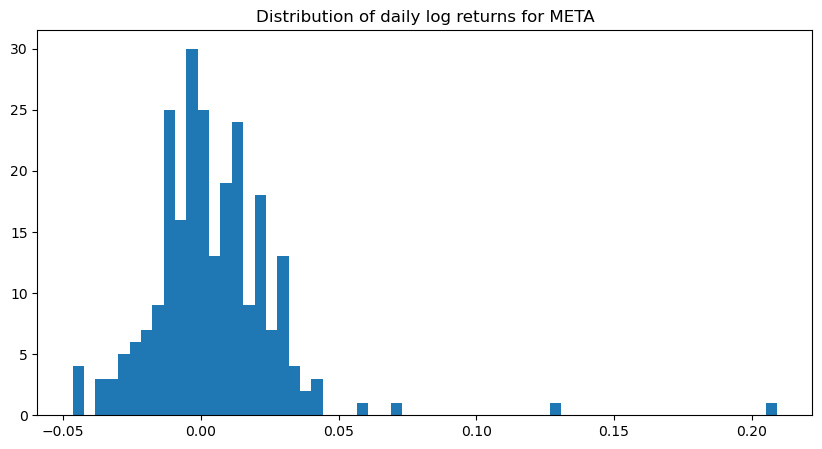

KS Statistic: 0.08559013482751249
P-value: 0.0490504572363506
The data is not normally distributed (reject H0).
Estimated degrees of freedom for a t-distribution: 9.17507561295113


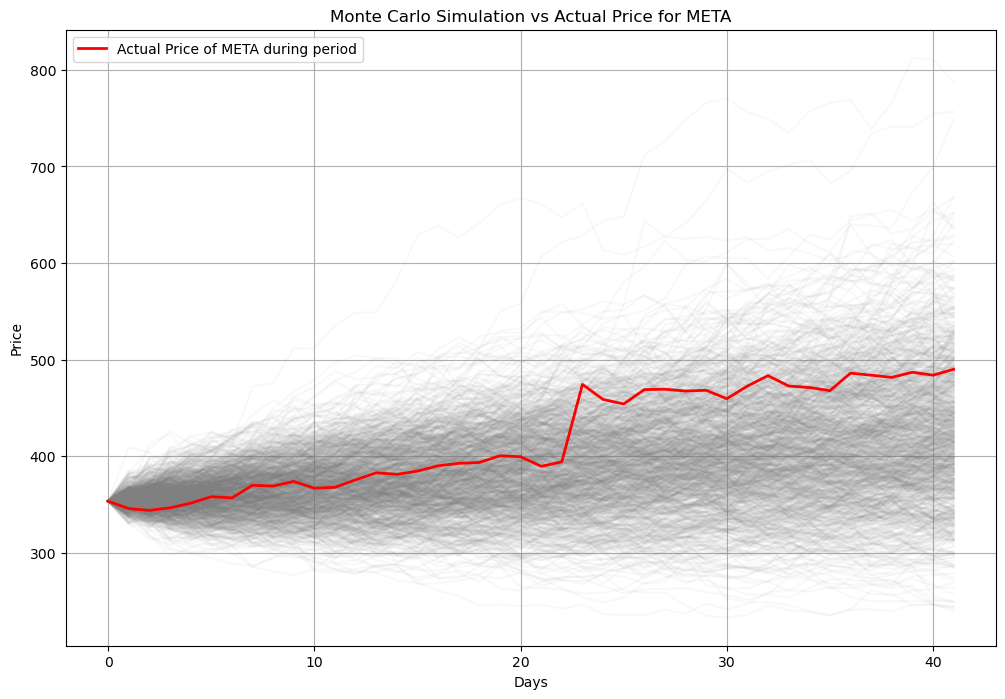

In [7]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats, optimize

np.random.seed(42)  ## for reproducible results

## Basic workflow to use:
## 1. Test price data to ensure returns are lognormal; if not, model Monte Carlo simulation as draws from t distribution instead.
## 2. Estimate parameters for Monte Carlo Simulation from returns on train period (we can use last year, 2023)
## 3. Run simulation for extended number of trials over variety of frequencies; report and plot result over a test period

## One Company Workflow. Test period is YTD returns.

test_ticker = 'META'
train_data_start_date = '2023-01-01'
train_data_end_date = '2024-01-01'
test_data_start_date = '2024-01-01'
test_data_end_date = '2025-01-01'

data = yf.Ticker(test_ticker).history(start=train_data_start_date, 
                                      end=train_data_end_date)
daily_log_ret = (np.log(data['Close']) - np.log(data['Close'].shift(1))).dropna()

## This is the 2024 YTD data we are aiming to simulate
test_data = yf.Ticker(test_ticker).history(start=test_data_start_date,
                                           end=test_data_end_date)
actual_prices = test_data['Close']

print(f"Monte Carlo simulation for {test_ticker} in 2024, going up to {test_data.index[-1].strftime('%D')}.")
print(f"Simulating {len(test_data)} days of returns.")

## Perform the one-sample K-S test for normal distribution with empirical parameters
ks_statistic, p_value = stats.kstest(daily_log_ret, 'norm', args=(daily_log_ret.mean(), daily_log_ret.std()))

## Print the results
print(f'Log Return Drift (Mean Daily Return): {daily_log_ret.mean()}')
print(f'Log Return Variance (Mean Daily Standard Deviation): {daily_log_ret.std()}\n')

plt.figure(figsize=(10,5))
plt.hist(daily_log_ret, bins=int(len(daily_log_ret)/4))
plt.title(f"Distribution of daily log returns for {test_ticker}")
plt.show()

print(f'KS Statistic: {ks_statistic}')
print(f'P-value: {p_value}')

## Interpret the results
alpha = 0.05  # Significance level for normality assumption
if p_value < alpha:
    print("The data is not normally distributed (reject H0).")
    
    ## We now want to estimate the degrees of freedom for the t-distribution to be drawn from
    ## in the simulation. For this t-distribution, we will assume the mean and standard deviation
    ## is the empirically observed variants.

    ## Initial guess for df degrees of freedom
    initial_guess = 10

    ## Optimize the negative log likelihood function
    result = optimize.minimize(neg_log_likelihood, initial_guess, args=(daily_log_ret,), bounds=[(2, 300)])

    ## Extract the estimated DF
    estimated_df = result.x[0]

    print(f"Estimated degrees of freedom for a t-distribution: {estimated_df}")
else:
    print("The data follows a normal distribution (fail to reject H0).")
    
print("==========================================")

## Parameters for Monte Carlo Simulation
S0 = data['Close'][-1]         ## Initial stock price
T = len(test_data)           # Timeframe in days (i.e. # of trading days so far in the year)
mu = daily_log_ret.mean()  # Estimated daily mean of log returns
sigma = daily_log_ret.std()  # Estimated daily standard deviation of log returns
simulations = 1000  # Number of Monte Carlo simulations

## Monte Carlo Simulation of Log Returns
if p_value < alpha: ## Data is not normally distributed
    log_returns = t.rvs(estimated_df, loc=mu, scale=sigma, size=(T, simulations))
else:
    log_returns = np.random.normal(mu, sigma, (T, simulations))

## Adding the 0th day to show progression from 2023 year-end price    
day_0 = np.zeros((1, simulations))
log_returns = np.vstack((day_0,log_returns))    
    
stock_prices = S0 * np.exp(np.cumsum(log_returns, axis=0))  ## Cumulative sum log returns to simulate paths

## Plotting the simulated paths and the actual path in comparison
plt.figure(figsize=(12,8))
plt.plot(stock_prices, color='gray', alpha=0.05)  ## Simulated prices, faded
plt.plot([S0] + list(actual_prices), label=f'Actual Price of {test_ticker} during period', 
         linewidth=2, color='red')  ## Actual prices
plt.title(f'Monte Carlo Simulation vs Actual Price for {test_ticker}')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

In [ ]:
## Ideas for next steps:
## 1. Build interface for entering tickers, modes of prediction (testing, or prediction into the future )
## 2. More robust estimation of simulation parameters: i.e. estimation of drift term, volatility term
## 2*. For drift, research methods, potentially incorporate risk factors and interest rates
## 2**. For volatility, research these methods as well, 

In [138]:
stock_prices.mean(axis=1)

array([353.58483887, 355.20360401, 356.27725808, 357.31773867,
       358.54591479, 360.34946895, 362.12789362, 364.53526535,
       365.89105167, 367.58109789, 369.41259834, 371.10141722,
       372.8381288 , 374.29410666, 376.06403146, 378.09652636,
       380.5135899 , 382.25890423, 384.24477359, 386.02687808,
       387.55340584, 389.10052997, 391.0005029 , 393.0202021 ,
       395.15654932, 396.59886625, 398.32595943, 399.54680223,
       401.65101578, 403.30512054, 405.10178113, 406.90118283,
       408.37099288, 410.30937115, 412.32653779, 413.95311482,
       415.87610684, 417.19027244, 419.05396116, 421.10218236,
       423.14085536])

In [139]:
stock_prices.std(axis=1)

array([ 0.        ,  9.28981133, 13.41459949, 17.22770621, 19.67623989,
       21.6634627 , 23.3925494 , 25.72868051, 27.68351731, 29.53301702,
       31.19868838, 33.25791732, 35.23028487, 36.82948945, 38.3489811 ,
       40.22389364, 41.61326358, 43.07567059, 44.10461218, 45.55320234,
       46.85325458, 48.47890666, 50.08789924, 51.50570821, 52.30731926,
       53.12424379, 55.26796528, 56.23893344, 57.58462889, 59.31056943,
       60.78549839, 62.08033565, 62.58318603, 64.00513489, 65.14520891,
       66.17965617, 68.05230048, 69.20116318, 70.1511385 , 71.48863454,
       73.61200944])

In [70]:
log_returns.shape

(20, 1000)

In [93]:
test_data.index

DatetimeIndex(['2024-01-02 00:00:00-05:00', '2024-01-03 00:00:00-05:00',
               '2024-01-04 00:00:00-05:00', '2024-01-05 00:00:00-05:00',
               '2024-01-08 00:00:00-05:00', '2024-01-09 00:00:00-05:00',
               '2024-01-10 00:00:00-05:00', '2024-01-11 00:00:00-05:00',
               '2024-01-12 00:00:00-05:00', '2024-01-16 00:00:00-05:00',
               '2024-01-17 00:00:00-05:00', '2024-01-18 00:00:00-05:00',
               '2024-01-19 00:00:00-05:00', '2024-01-22 00:00:00-05:00',
               '2024-01-23 00:00:00-05:00', '2024-01-24 00:00:00-05:00',
               '2024-01-25 00:00:00-05:00', '2024-01-26 00:00:00-05:00',
               '2024-01-29 00:00:00-05:00', '2024-01-30 00:00:00-05:00'],
              dtype='datetime64[ns, America/New_York]', name='Date', freq=None)